## Analysis with GeoPandas
In this exercise, we use GeoPandas to identify census tracts within 1km of EV charging locations in a region in NC. 
* [Input/Output](https://geopandas.org/io.html) Reading a CSV file into a GeoPandas geodataframe
* [Index and Selecting data](https://geopandas.org/indexing.html): Subsetting records
* [Managing Projections](https://geopandas.org/projections.html): Projecting a geodataframe
* [Geometric manipulations](https://geopandas.org/geometric_manipulations.html): Buffering points
* [Set operations](https://geopandas.org/set_operations.html): intersect
* [Aggregrating data](https://geopandas.org/aggregation_with_dissolve.html): Dissolving features

#### ♦Step 1. Import packages needed in the analysis
>**Knowledge check**:<br>
→ Can you explain what each package imported above does?

In [1]:
#Import packages
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

import matplotlib.pyplot as plt
import contextily as ctx

%matplotlib inline

#### ♦Step 2. Create a geodataframe from a CSV file
As done in a previous notebook, we want to:
1. Import a CSV file containing coordinate columns into a Pandas dataframe,
1. Create a collection of Shapely points from the coordinate fields, and 
1. Create a geodataframe from the components. 

In [100]:
#Read in charging stations CSV, convert to geodataframe
df = pd.read_csv('./data/NC_Charging_Stations.csv')
geom = [Point(xy) for xy in zip(df['Longitude'],df['Latitude'])]
gdf_stations_all = gpd.GeoDataFrame(df,geometry=geom,crs=4326)

#### ♦Step 3. Explore the data in geodataframe
Have a quick look at the contents imported. Things to check include:
* How many rows and columns were imported
* The names, data types, and number of non-null values in each column
* Summary statistics of numeric columns, if applicable
* Correlations among column values, if applicable
* Spatial plot of the data

In [4]:
#Examine the data
gdf_stations_all.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 738 entries, 0 to 737
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   index                             738 non-null    int64   
 1   Fuel Type Code                    738 non-null    object  
 2   Station Name                      738 non-null    object  
 3   City                              738 non-null    object  
 4   State                             738 non-null    object  
 5   ZIP                               738 non-null    int64   
 6   Status Code                       738 non-null    object  
 7   Groups With Access Code           738 non-null    object  
 8   Latitude                          738 non-null    float64 
 9   Longitude                         738 non-null    float64 
 10  ID                                738 non-null    int64   
 11  Updated At                        738 non-null    

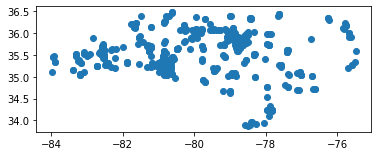

In [7]:
#Plot the data
gdf_stations_all.plot();

---
#### ►TASK: Import the USGS gage points for NC: `./data/gages.csv`
* Convert data to a dataframe: `gdf_gages`
* Explore the data
* Plot the gage sites

---
### Importing NC Census Block Group features via NC OneMap's web service
We will explore web services a bit later, but we'll use the code below to acquire polygon data of census block groups for Durham, Wake, and Orange counties. 

In [44]:
def getOneMapData(serviceName, layer, query='OBJECTID>0'):
    url=f'https://services.nconemap.gov/secure/rest/services/{serviceName}/' + \
        f'FeatureServer/{layer}/query?where={query}&outFields=*&f=geojson'
    try:
        gdf = gpd.read_file(url)
    except:
        print("Error fetching data")
        print (url)
        return None
    return gdf

In [66]:
#Fetch census block groups for Durham, Orange, and Wake counties
gdf_DurmBlkGroups = getOneMapData('NC1Map_Census',5,"BGROUP+LIKE+'37063%25'")
gdf_WakeBlkGroups = getOneMapData('NC1Map_Census',5,"BGROUP+LIKE+'37183%25'")
gdf_OrangeBlkGroups = getOneMapData('NC1Map_Census',5,"BGROUP+LIKE+'37135%25'")

In [69]:
#Fetch census block groups for Durham, Orange, and Wake counties
gdf_DurmBlkGroups = getOneMapData('NC1Map_Census',8,"GEOID10+LIKE+'37063%25'")
gdf_WakeBlkGroups = getOneMapData('NC1Map_Census',8,"GEOID10+LIKE+'37183%25'")
gdf_OrangeBlkGroups = getOneMapData('NC1Map_Census',8,"GEOID10+LIKE+'37135%25'")

In [43]:
#Challenge: See if you can fetch Chatham county block groups (FIPS = 37037)

'https://services.nconemap.gov/secure/rest/services/NC1Map_Parcels/FeatureServer/1/query?where=STCNTYFIPS="03063"&outFields=*&f=geojson'

In [78]:
#Explore one of the dataframes
gdf_DurmBlkGroups.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [71]:
gdf_DurmBlkGroups.iloc[0]

GEOID10                                                                  370630020072
TOTAL_POP                                                                        2306
onemap.SDEADMIN.CENBG2010_SV.fid                                                  568
geometry                            POLYGON ((-78.93115770704857 35.95827210689065...
Name: 0, dtype: object

<AxesSubplot:>

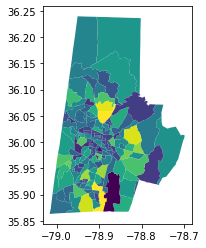

In [77]:
#Plot Durhham's population
gdf_DurmBlkGroups.plot('TOTAL_POP',cmap='viridis')

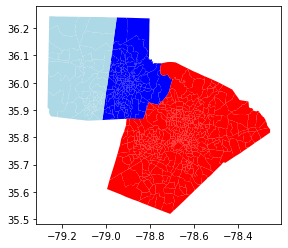

In [61]:
#Plot the block groups
thePlot = gdf_DurmBlkGroups.plot(color='blue')
gdf_WakeBlkGroups.plot(ax=thePlot,color='red')
gdf_OrangeBlkGroups.plot(ax=thePlot,color='lightblue');

### The analysis
Now that we've obtained a few datasets and got them into geodataframes, we'll perform some analysis. These include:
* Subsetting the EV charging stations for those in specific cities
* Identifying the census blocks surrounding each EV station, within a distance of 1km
 * To do this, we'll merge the Durham, Wake, and Orange Co block data selected above
 * Then we'll buffer our selected EV station points a distance of 1km
 * And finally, we'll select blocks that intersect the EV station buffers

#### Analysis Step 1. Attribute subset of EV Station data
1. Examine unique values in the city column

In [83]:
gdf_stations_all.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 738 entries, 0 to 737
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   index                             738 non-null    int64   
 1   Fuel Type Code                    738 non-null    object  
 2   Station Name                      738 non-null    object  
 3   City                              738 non-null    object  
 4   State                             738 non-null    object  
 5   ZIP                               738 non-null    int64   
 6   Status Code                       738 non-null    object  
 7   Groups With Access Code           738 non-null    object  
 8   Latitude                          738 non-null    float64 
 9   Longitude                         738 non-null    float64 
 10  ID                                738 non-null    int64   
 11  Updated At                        738 non-null    

In [102]:
#Reveal the unique values in the City column
gdf_stations_all['City'].unique()

array(['Charlotte', 'Raleigh', 'Concord', 'Fayetteville', 'High Point',
       'Lumberton', 'Durham', 'Sanford', 'Burlington', 'Asheville',
       'Cary', 'Boone', 'Forest City', 'Gastonia', 'Goldsboro',
       'Greensboro', 'Greenville', 'Hendersonville', 'Hickory',
       'Jacksonville', 'Montreat', 'New Bern', 'Reidsville',
       'Roanoke Rapids', 'Rockingham', 'Mount Airy', 'Salisbury',
       'Southern Pines', 'Statesville', 'Wake Forest', 'Wilkesboro',
       'Wilmington', 'Wilson', 'Winston-Salem', 'Clyde', 'Cornelius',
       'Elizabeth City', 'Asheboro', 'Black Mountain', 'Chapel Hill',
       'Hillsborough', 'Cherokee', 'Flat Rock', 'Clinton',
       'Kings Mountain', 'Knightdale', 'Mt. Holly', 'Mooresville',
       'Weaverville', 'Fletcher', 'Pittsboro', 'Belmont', 'Lowell',
       'Apex', 'Dallas', 'Lincolnton', 'Arden', 'Kernsersville', 'Buxton',
       'Mebane', 'Point Harbor', 'Nags Head', 'Denton', 'Robbinsville',
       'Beaufort', 'Highlands', 'Maiden', 'Huntersville

<AxesSubplot:>

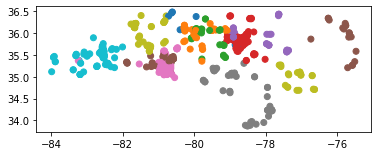

In [99]:
#Subset records where the City is "Durham", "Raleigh", or "Chapel Hill"

In [ ]:
#List unique values in the City field
gdf_stations_all['City'].unique()

In [ ]:
#Subset records near Durham, Raleigh, Cary, and Chapel Hill
gdf_stations = gdf_stations_all.query('City in ("Durham","Raleigh","Cary","Chapel Hill")')
#Plot the results
gdf_stations.plot("City");

In [ ]:
#Plot them with a base map
fig, ax = plt.subplots(figsize = (10,5))
gdf_stations.to_crs(3857).plot(ax=ax, column="City")
ctx.add_basemap(ax)

* Buffer the points. 
 * To do this, first we need to project the data to a crs that uses meters: UTM Zone 17N. To find the EPSG number associated with this crs, navigate to https://epsg.org and search for `UTM Zone 17 N`. In the results, find the entry associated with WGS84, and record its epsg number. (It should be 32617.)

In [ ]:
#Transform stations to UTM Zone 17N 
gdf_stations_utm = gdf_stations.to_crs(32617)
print(gdf_stations_utm.crs)

In [ ]:
#Buffer the selected exits 2.5 km
gdf_stations_buffer = gdf_stations_utm.buffer(2500)
gdf_stations_buffer.plot(alpha=0.2);

Now we are going to fetch a dataset of NC Census Tracts. We'll use a Census web service that allows us to fetch data from an online query in GeoJSON format. 

In [ ]:
#Get Census Tracts
query_url = 'https://tigerweb.geo.census.gov/arcgis/rest/services/Generalized_ACS2019/Tracts_Blocks/MapServer/3/query?where=State+%3D+37&outFields=*&f=geojson'
gdf_Tracts = gpd.read_file(query_url)
#Show the shape of the returned dataframe
gdf_Tracts.shape

In [ ]:
gdf_Tracts.info()

In [ ]:
print(gdf_Tracts.crs)

In [ ]:
#plot points on tracts
ax = gdf_Tracts.plot('COUNTY',figsize=(12,6))
gdf_stations.plot(ax=ax,markersize=10,color="black");

In [ ]:
#Dissolve Tracts on Counties
gdf_Counties = gdf_Tracts.dissolve(by='COUNTY',aggfunc={'AREALAND':'sum'})
gdf_Counties.head()

In [ ]:
#plot points on tracts
ax = gdf_Counties.plot('AREALAND',figsize=(12,6))
gdf_stations.plot(ax=ax,markersize=10,color="black");